# 8 DeepAR
## a Data preparation on local
Data source: [kaggle_DailyDelhiClimate](https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data?select=DailyDelhiClimateTrain.csv])

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_rows", 6)

In [2]:
# Load dataset
dataset = pd.read_csv("D:/3. Projects/AWS Sagemaker/practice/S3/sagemaker-tutorial-rnd/DeepAR/DailyClimate.csv",
                     parse_dates=["date"], index_col=0)
dataset

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
...,...,...,...,...
2016-12-30,14.095238,89.666667,6.266667,1017.904762
2016-12-31,15.052632,87.000000,7.325000,1016.100000
2017-01-01,10.000000,100.000000,0.000000,1016.000000


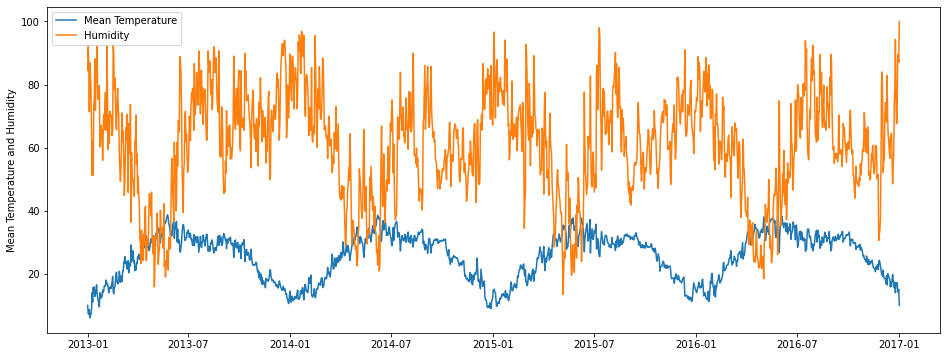

In [3]:
# Plot the Mean Temperature and Humidity
plt.figure(figsize=(16,6))
plt.plot(dataset.index, dataset["meantemp"], label="Mean Temperature")
plt.plot(dataset.index, dataset["humidity"], label="Humidity")
plt.ylabel("Mean Temperature and Humidity")
plt.legend(loc="upper left")
plt.show()

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


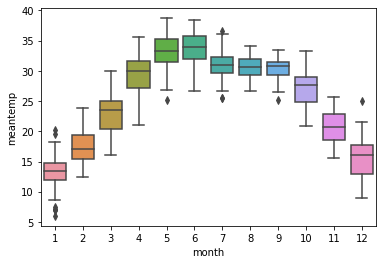

In [5]:
# Generate month feature
data = dataset.loc[:,:]
data["month"] = data.index
data["month"] = data["month"].dt.month
sns.boxplot(data=data, y="meantemp", x="month")
plt.show()

In [6]:
# Generate midyear or not
data["midyear"] = np.where(((data["month"] >= 4) & (data["month"] <= 10)), 1, 0)
data = data.drop(columns=["month"])
data

,meantemp,humidity,wind_speed,meanpressure,midyear
date,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,0
2013-01-02,7.400000,92.000000,2.980000,1017.800000,0
2013-01-03,7.166667,87.000000,4.633333,1018.666667,0
...,...,...,...,...,...
2016-12-30,14.095238,89.666667,6.266667,1017.904762,0
2016-12-31,15.052632,87.000000,7.325000,1016.100000,0
2017-01-01,10.000000,100.000000,0.000000,1016.000000,0


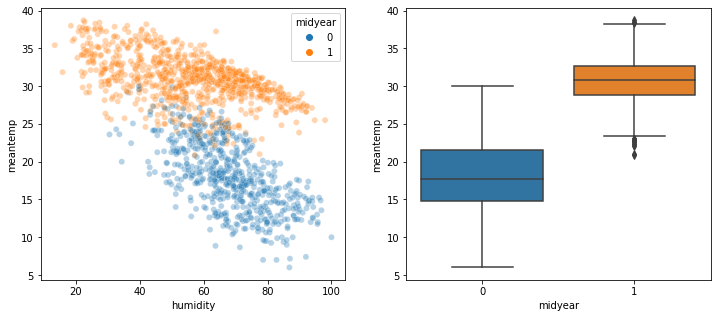

In [7]:
# Plot meant temp vs mid year and humidity
fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.scatterplot(data=data, y="meantemp", x="humidity", hue="midyear", alpha=0.33, ax=axes[0])
sns.boxplot(data=data, y="meantemp", x="midyear", ax=axes[1])
plt.show()

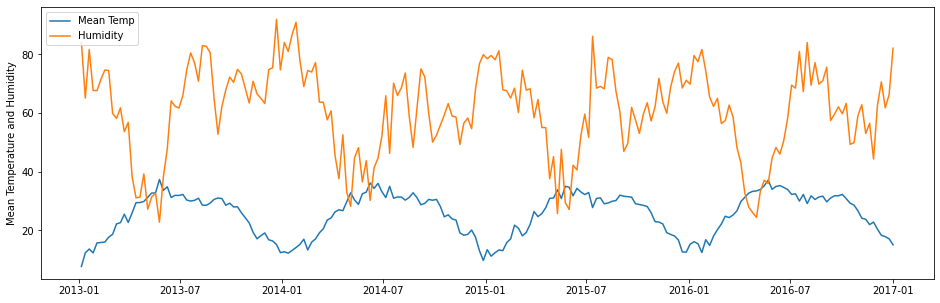

In [12]:
# Resample the data to weekly data
# Later the model predict the weekly average temperature
data_1w = data.resample("1w").mean()

plt.figure(figsize=(16,5))
plt.plot(data_1w.index, data_1w["meantemp"], label="Mean Temp")
plt.plot(data_1w.index, data_1w["humidity"], label="Humidity")
plt.ylabel("Mean Temperature and Humidity")
plt.legend(loc="upper left")
plt.show()

In [11]:
data_1w

,meantemp,humidity,wind_speed,meanpressure,midyear
date,,,,,
2013-01-06,7.705556,84.077778,2.337778,1017.300000,0.0
2013-01-13,12.343537,65.145238,8.825170,1016.632653,0.0
2013-01-20,13.642857,81.663265,4.242857,1017.139456,0.0
...,...,...,...,...,...
2016-12-18,17.871140,61.808297,5.955406,1016.727185,0.0
2016-12-25,17.123006,66.346011,9.636147,1014.901237,0.0
2017-01-01,15.085173,82.139204,5.751243,1016.661017,0.0


In [13]:
# Ensure that there is no null data. Otherwise, filling missing data is required.
data_1w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 209 entries, 2013-01-06 to 2017-01-01
Freq: W-SUN
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      209 non-null    float64
 1   humidity      209 non-null    float64
 2   wind_speed    209 non-null    float64
 3   meanpressure  209 non-null    float64
 4   midyear       209 non-null    float64
dtypes: float64(5)
memory usage: 9.8 KB


In [14]:
data_1w.corr()
# Mean Temp has high correlation with humidity and midyear

,meantemp,humidity,wind_speed,meanpressure,midyear
meantemp,1.000000,-0.591163,0.494461,-0.065283,0.883260
humidity,-0.591163,1.000000,-0.524240,-0.055789,-0.416801
wind_speed,0.494461,-0.524240,1.000000,-0.062036,0.384775
meanpressure,-0.065283,-0.055789,-0.062036,1.000000,-0.118821
midyear,0.883260,-0.416801,0.384775,-0.118821,1.000000


In [15]:
# Save the the weekly data_1w
data_1w[["meantemp", "humidity", "midyear"]].to_csv("D:/3. Projects/AWS Sagemaker/practice/S3/sagemaker-tutorial-rnd/DeepAR/data_1w.csv", index=True, index_label='date')

In [17]:
# Split train, validation, and test data
# The train data: from the beginning until 2015-12
# The validation data: 2016-01 until 2016-06
# The test data: 2016-07 until the end
train = data_1w[data_1w.index<"2016-07"][["meantemp", "humidity", "midyear"]]
test = data_1w[data_1w.index>="2016-07"][["meantemp", "humidity", "midyear"]]

In [18]:
train

,meantemp,humidity,midyear
date,,,
2013-01-06,7.705556,84.077778,0.0
2013-01-13,12.343537,65.145238,0.0
2013-01-20,13.642857,81.663265,0.0
...,...,...,...
2016-06-12,35.275595,46.029592,1.0
2016-06-19,34.646854,50.665901,1.0
2016-06-26,33.930913,58.358660,1.0


In [19]:
test

,meantemp,humidity,midyear
date,,,
2016-07-03,32.289626,69.560204,1.0
2016-07-10,32.473810,68.526190,1.0
2016-07-17,29.991071,81.053571,1.0
...,...,...,...
2016-12-18,17.871140,61.808297,0.0
2016-12-25,17.123006,66.346011,0.0
2017-01-01,15.085173,82.139204,0.0


In [20]:
# Save the test data
test.to_csv("D:/3. Projects/AWS Sagemaker/practice/S3/sagemaker-tutorial-rnd/DeepAR/test_climate.csv", index=True, index_label='date')

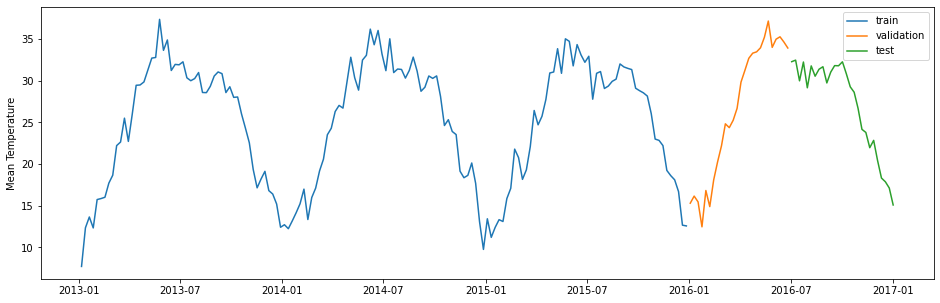

In [21]:
# Plot train and test data
plt.figure(figsize=(16,5))
plt.plot(train[train.index<"2016-01"].index, train[train.index<"2016-01"]["meantemp"], label="train")
plt.plot(train[train.index>="2016-01"].index, train[train.index>="2016-01"]["meantemp"], label="validation")
plt.plot(test.index, test["meantemp"], label="test")
plt.ylabel("Mean Temperature")
plt.legend()
plt.show()

In [22]:
# Save the train and test dataset in json format, cited from AWS ???
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]  
# The target variable may have NaN value as "NaN" in string, but the categories and dynamic features must not do.

def encode_dynamic_feat(dynamic_feat):  
    l = []
    for col in dynamic_feat:
        assert (not dynamic_feat[col].isna().any()), col  + ' has NaN'             
        l.append(dynamic_feat[col].tolist())
    return l

def series_to_obj(ts, cat=None, dynamic_feat=None):
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = encode_dynamic_feat(dynamic_feat)
    return obj

def series_to_jsonline(ts, cat=None, dynamic_feat=None):
    return json.dumps(series_to_obj(ts, cat, dynamic_feat))   

In [23]:
# Try to serialize the first few rows.
# This will be the json format to save
series_to_jsonline(
    ts = train.loc[train.index<"2013-02", "meantemp"],
    cat = None,
    dynamic_feat=train.loc[train.index<"2013-02"][["humidity", "midyear"]],
)
# The dynamic feature is optional. The model can work with only target variable without any dynamic features.
# In this demonstration, 2 dynamica features will be used.

'{"start": "2013-01-06 00:00:00", "target": [7.705555555555556, 12.34353741496599, 13.642857142857142, 12.329591836734695], "dynamic_feat": [[84.07777777777777, 65.1452380952381, 81.66326530612245, 67.74829931972789], [0.0, 0.0, 0.0, 0.0]]}'

In [24]:
# Save as json format
with open("D:/3. Projects/AWS Sagemaker/practice/S3/sagemaker-tutorial-rnd/DeepAR/train_climate.json", 'wb') as f:
    f.write(series_to_jsonline(
        train.loc[train.index < "2016-01", "meantemp"],
        cat=None,
        dynamic_feat=train[train.index < "2016-01"][["humidity", "midyear"]]).encode("utf-8")
    )
    f.write('\n'.encode("utf-8"))

In [25]:
with open("D:/3. Projects/AWS Sagemaker/practice/S3/sagemaker-tutorial-rnd/DeepAR/validation_climate.json", 'wb') as f:
    f.write(series_to_jsonline(
        train.loc[:, "meantemp"],
        cat=None,
        dynamic_feat=train[["humidity", "midyear"]]).encode("utf-8")
    )
    f.write('\n'.encode("utf-8"))

"Categories" is used if there are more than 1 target variables.

For example, if mean temp and humidity are the two target variables to forecast, then categories can be used. The categories are mean temp and humidity with their own time-series.

This demonstration does not use categories.

In [ ]:
# Example of using categories
with open("D:/3. Projects/AWS Sagemaker/practice/S3/sagemaker-tutorial-rnd/DeepAR/categories_example.json", 'wb') as f:
    f.write(series_to_jsonline(
        train.loc[train.index<"2013-02", "meantemp"],
        cat=[0],
    )
    f.write('\n'.encode("utf-8"))
    f.write(series_to_jsonline(
        train.loc[train.index<"2013-02", "humidity"],
        cat=[1],
    )